In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'



data = pd.read_csv("nyc_dataset.csv")
print(data.head())
print(data.info())
print(data.describe())

   requestid       boro    yr  m  d  hh  mm  vol  segmentid  \
0      16787  Manhattan  2014  3  2   0  45   21      37269   
1      16787  Manhattan  2014  3  2   1   0    9      37269   
2      16787  Manhattan  2014  3  2   1  15    9      37269   
3      16787  Manhattan  2014  3  2   1  30   13      37269   
4      16787  Manhattan  2014  3  2   1  45    6      37269   

                     wktgeom        street   fromst     tost direction  
0  POINT (991497.1 229579.5)  RIVERSIDE DR  W 98 ST  W 97 ST        NB  
1  POINT (991497.1 229579.5)  RIVERSIDE DR  W 98 ST  W 97 ST        NB  
2  POINT (991497.1 229579.5)  RIVERSIDE DR  W 98 ST  W 97 ST        NB  
3  POINT (991497.1 229579.5)  RIVERSIDE DR  W 98 ST  W 97 ST        NB  
4  POINT (991497.1 229579.5)  RIVERSIDE DR  W 98 ST  W 97 ST        NB  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301951 entries, 0 to 301950
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------  

In [ ]:
data['datetime'] = pd.to_datetime(dict(
    year=data['yr'],
    month=data['m'],
    day=data['d'],
    hour=data['hh'],
    minute=data['mm']
), errors='coerce')

print(data[['datetime']].head())
print(data.info())


data['day_of_week'] = data['datetime'].dt.dayofweek

             datetime
0 2014-03-02 00:45:00
1 2014-03-02 01:00:00
2 2014-03-02 01:15:00
3 2014-03-02 01:30:00
4 2014-03-02 01:45:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301951 entries, 0 to 301950
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   requestid  301951 non-null  int64         
 1   boro       301951 non-null  object        
 2   yr         301951 non-null  int64         
 3   m          301951 non-null  int64         
 4   d          301951 non-null  int64         
 5   hh         301951 non-null  int64         
 6   mm         301951 non-null  int64         
 7   vol        301951 non-null  int64         
 8   segmentid  301951 non-null  int64         
 9   wktgeom    301951 non-null  object        
 10  street     301950 non-null  object        
 11  fromst     301950 non-null  object        
 12  tost       301950 non-null  object        
 13  direction  301950 non-null  obje

In [ ]:
data = data.drop_duplicates()

In [ ]:
print("\nMissing values before cleaning:\n", data.isnull().sum())


Missing values before cleaning:
 requestid      0
boro           0
yr             0
m              0
d              0
hh             0
mm             0
vol            0
segmentid      0
wktgeom        0
street         1
fromst         1
tost           1
direction      1
datetime       0
day_of_week    0
dtype: int64


In [ ]:
critical_cols = ['yr', 'm', 'd', 'hh', 'mm', 'vol']
data = data.dropna(subset=critical_cols)

In [ ]:
data = data.dropna(subset=['fromst', 'tost', 'direction'])

drop_cols = ['requestid', 'boro', 'segmentid', 'wktgeom',
             'street', 'fromst', 'tost', 'direction']
data = data.drop(columns=drop_cols, errors='ignore')

print("Final columns kept for modeling/visualization:", data.columns.tolist())


Final columns kept for modeling/visualization: ['yr', 'm', 'd', 'hh', 'mm', 'vol', 'datetime', 'day_of_week']


In [ ]:
print("\nMissing values after cleaning:\n", data.isnull().sum())


Missing values after cleaning:
 yr             0
m              0
d              0
hh             0
mm             0
vol            0
datetime       0
day_of_week    0
dtype: int64


/tmp/ipython-input-2248651989.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=data['hh'], y=data['vol'], estimator='mean', ci=None, color="blue")


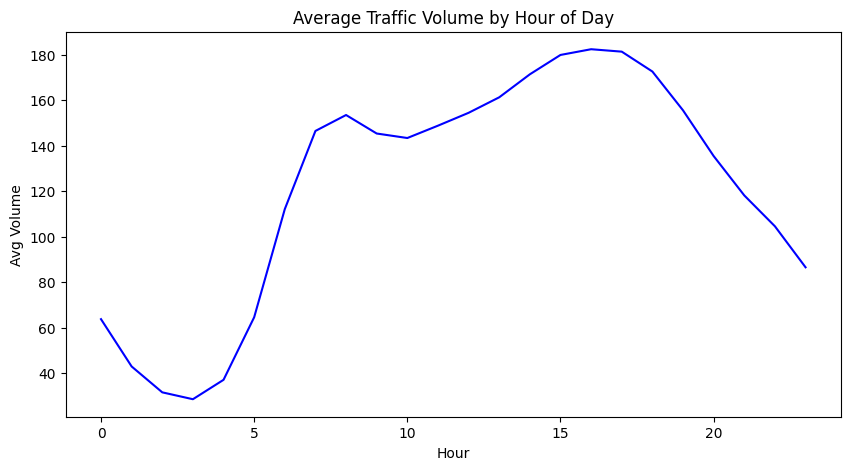

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=data['hh'], y=data['vol'], estimator='mean', ci=None, color="blue")
plt.title("Average Traffic Volume by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Avg Volume")
plt.show()

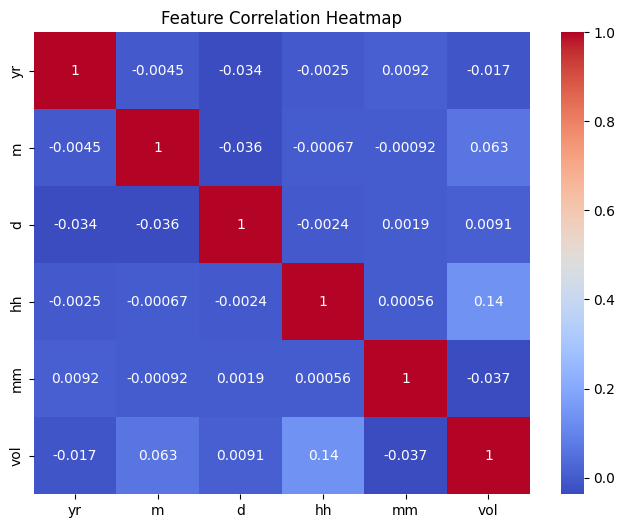

In [ ]:
numeric_data = data.select_dtypes(include=["int64", "float64"])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
features = ["vol", "day_of_week", "hh"]
target = "vol"

dataset = data[features].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len = int(np.ceil(len(dataset) * 0.95))

train_data = scaled_data[:training_data_len]

X_train, y_train = [], []
window_size = 60   # use past 60 timesteps
horizon = 1        # predict next timestep

for i in range(window_size, len(train_data) - horizon):
    X_train.append(train_data[i - window_size:i])
    y_train.append(train_data[i + horizon - 1, 0])  # predict volume

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)  # output volume
])

model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,881 (230.00 KB)

 Trainable params: 58,881 (230.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
data['vol'] = np.log1p(data['vol'])   # log(1+x)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
8066/8066 ━━━━━━━━━━━━━━━━━━━━ 90s 10ms/step - loss: 4.6460e-04 - root_mean_squared_error: 0.0206 - val_loss: 1.1945e-04 - val_root_mean_squared_error: 0.0109
Epoch 2/20
8066/8066 ━━━━━━━━━━━━━━━━━━━━ 73s 9ms/step - loss: 1.6907e-04 - root_mean_squared_error: 0.0130 - val_loss: 6.7731e-05 - val_root_mean_squared_error: 0.0082
Epoch 3/20
8066/8066 ━━━━━━━━━━━━━━━━━━━━ 71s 9ms/step - loss: 1.6233e-04 - root_mean_squared_error: 0.0127 - val_loss: 4.4435e-05 - val_root_mean_squared_error: 0.0067
Epoch 4/20
8066/8066 ━━━━━━━━━━━━━━━━━━━━ 72s 9ms/step - loss: 1.5540e-04 - root_mean_squared_error: 0.0125 - val_loss: 5.1014e-05 - val_root_mean_squared_error: 0.0071
Epoch 5/20
8066/8066 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - loss: 1.5000e-04 - root_mean_squared_error: 0.0122 - val_loss: 5.3829e-05 - val_root_mean_squared_error: 0.0073
Epoch 6/20
8066/8066 ━━━━━━━━━━━━━━━━━━━━ 71s 9ms/step - loss: 1.4836e-04 - root_mean_squared_error: 0.0122 - val_loss: 3.9934e-05 - val_root_mean_squared

In [ ]:
test_data = scaled_data[training_data_len - window_size:]

X_test, y_test = [], dataset[training_data_len:, 0]  # actual volume

for i in range(window_size, len(test_data) - horizon):
    X_test.append(test_data[i - window_size:i])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [ ]:
predictions = model.predict(X_test)

472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
# Keep only last 200k rows (or adjust)
data_small = data.tail(200_000).copy()


In [ ]:
future_steps = 3 * 365   # daily predictions for 3 years
freq = 'D'

In [ ]:
future_steps = 365  # predict 1 year daily for demo
last_window = X_test[-1]  # last known input

future_predictions = []
current_window = last_window.copy()

for _ in range(future_steps):
    pred = model.predict(current_window[np.newaxis, :, :], verbose=0)[0, 0]
    future_predictions.append(pred)
    current_window = np.roll(current_window, -1, axis=0)
    current_window[-1, 0] = pred


In [ ]:
print(data.columns)

Index(['yr', 'm', 'd', 'hh', 'mm', 'vol', 'datetime', 'day_of_week'], dtype='object')


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assume you have your target column (replace 'traffic_volume' with yours)
y = data['vol']   # <-- replace with the actual column name

  # <-- make sure this matches your dataset

# Create and fit the scaler
scaler_y = MinMaxScaler()
scaler_y.fit(y.values.reshape(-1, 1))   # 👈 this line is essential

# Now inverse transform predictions
future_predictions = np.array(future_predictions)
future_rescaled = scaler_y.inverse_transform(
    future_predictions.reshape(-1, 1)
).ravel()

In [ ]:
import numpy as np

# Ensure predictions are a numpy array
future_predictions = np.array(future_predictions)

# Now inverse transform
future_rescaled = scaler_y.inverse_transform(
    future_predictions.reshape(-1, 1)
).ravel()


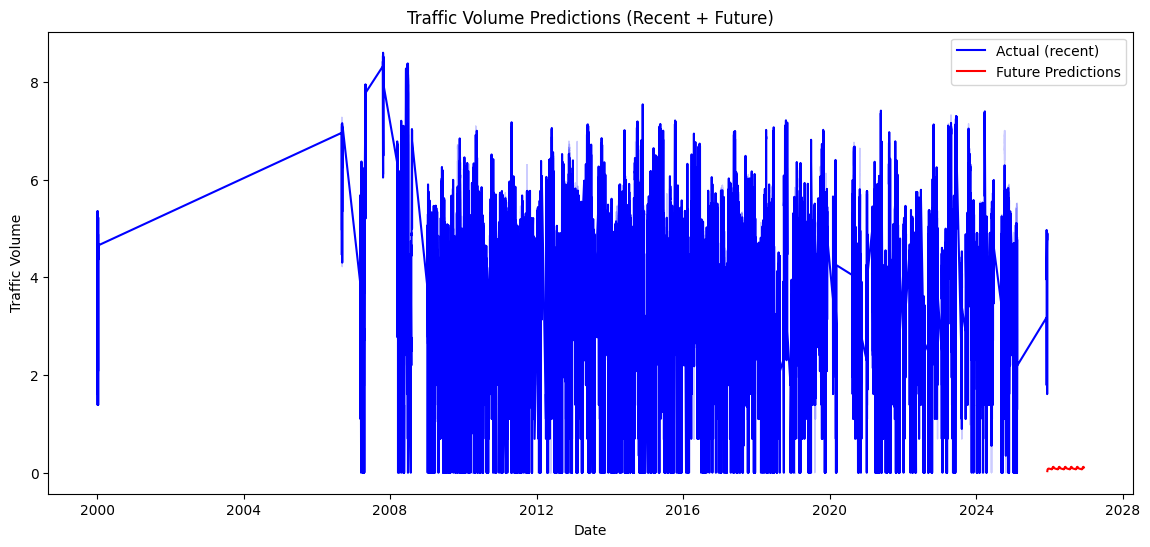

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scale only target column

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(data_small[['vol']])  # fit only on 'vol'




# 2. Inverse transform predictions

# future_predictions = model.predict(...)  # already scaled

future_rescaled = scaler_y.inverse_transform(
    future_predictions.reshape(-1, 1)
).ravel()  # back to original scale

# 3. Create future dates

last_date = data_small['datetime'].max()
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=len(future_rescaled),
    freq='D'
)

future_df = pd.DataFrame({
    'datetime': future_dates,
    'Predictions': future_rescaled
})

# 4. Plot

plt.figure(figsize=(14,6))
sns.lineplot(x='datetime', y='vol', data=data_small, label="Actual (recent)", color='blue')
sns.lineplot(x='datetime', y='Predictions', data=future_df, label="Future Predictions", color='red')
plt.title("Traffic Volume Predictions (Recent + Future)")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


In [ ]:
data_resampled = data_small.resample('M', on='datetime').mean().reset_index()

/tmp/ipython-input-1812981557.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_resampled = data_small.resample('M', on='datetime').mean().reset_index()


In [ ]:
recent_data = data_small[data_small['datetime'] > '2023-01-01']

In [ ]:
data_small['vol_smooth'] = data_small['vol'].rolling(window=7).mean()

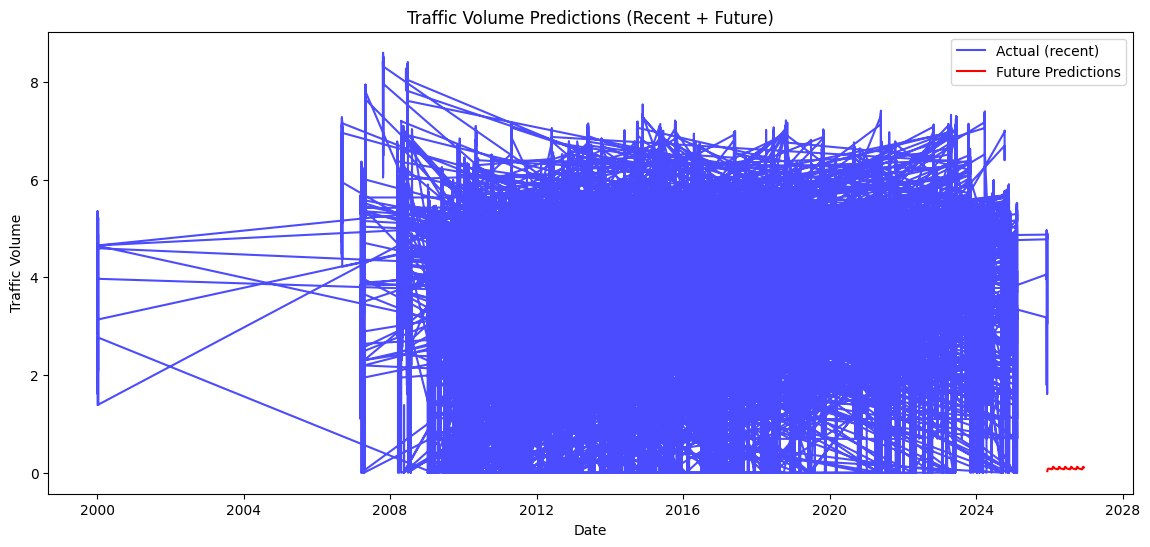

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(data_small['datetime'], data_small['vol'], label="Actual (recent)", color="blue", alpha=0.7)
plt.plot(future_df['datetime'], future_df['Predictions'], label="Future Predictions", color="red")
plt.title("Traffic Volume Predictions (Recent + Future)")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


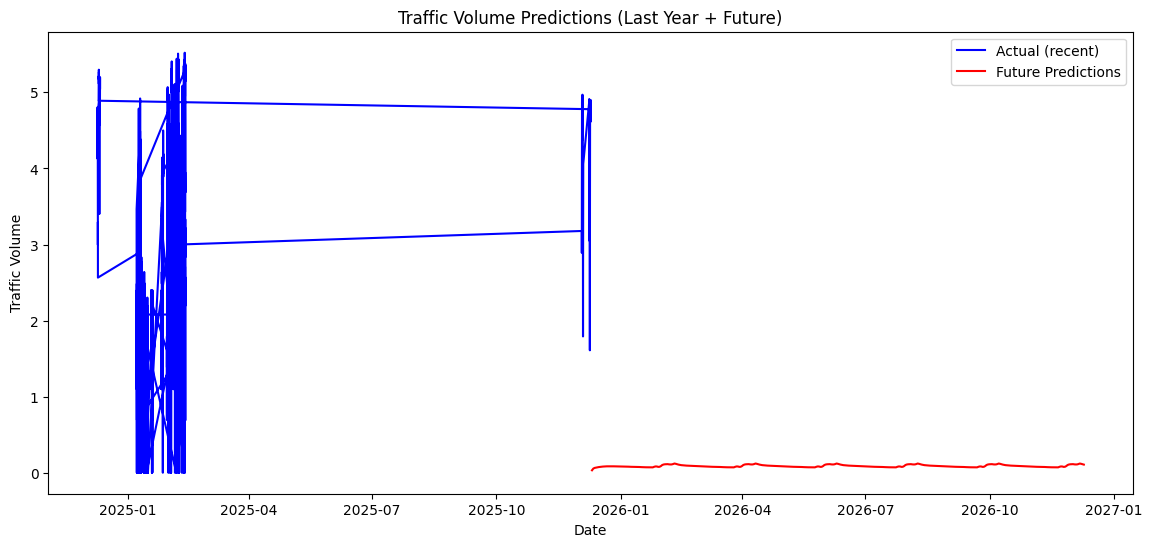

In [ ]:
# Filter last 1 year of data
recent_data = data_small[data_small['datetime'] > (data_small['datetime'].max() - pd.Timedelta(days=365))]

plt.figure(figsize=(14,6))
plt.plot(recent_data['datetime'], recent_data['vol'], label="Actual (recent)", color="blue")
plt.plot(future_df['datetime'], future_df['Predictions'], label="Future Predictions", color="red")
plt.title("Traffic Volume Predictions (Last Year + Future)")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


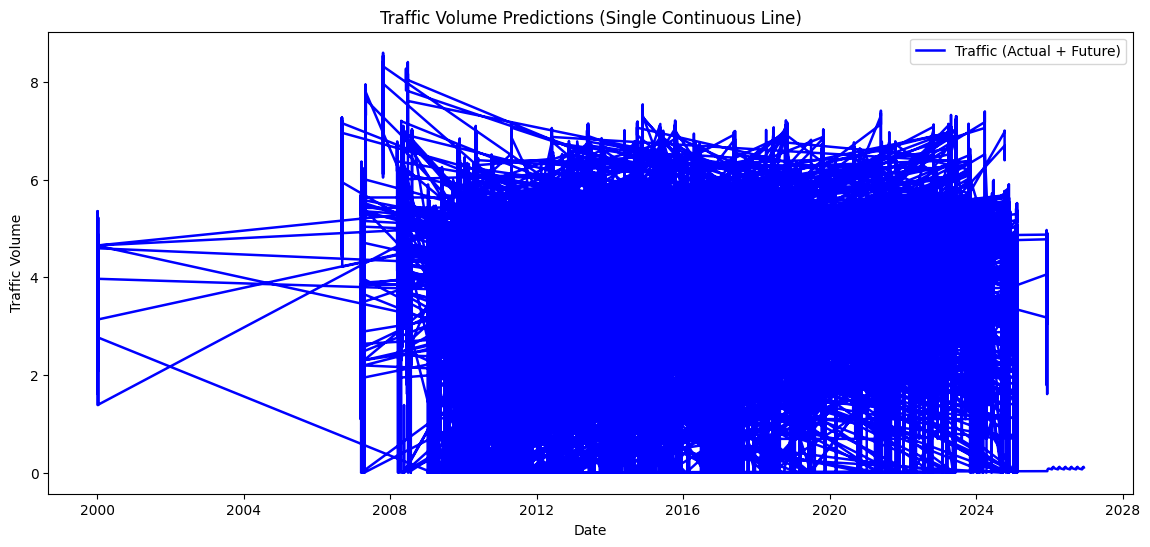

In [ ]:
# Merge actual + future into one dataframe
combined_df = pd.concat([
    data_small[['datetime', 'vol']].rename(columns={'vol': 'Traffic'}),
    future_df.rename(columns={'Predictions': 'Traffic'})
])

# Plot single continuous line
plt.figure(figsize=(14,6))
plt.plot(combined_df['datetime'], combined_df['Traffic'],
         color="blue", linewidth=1.8, label="Traffic (Actual + Future)")
plt.title("Traffic Volume Predictions (Single Continuous Line)")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


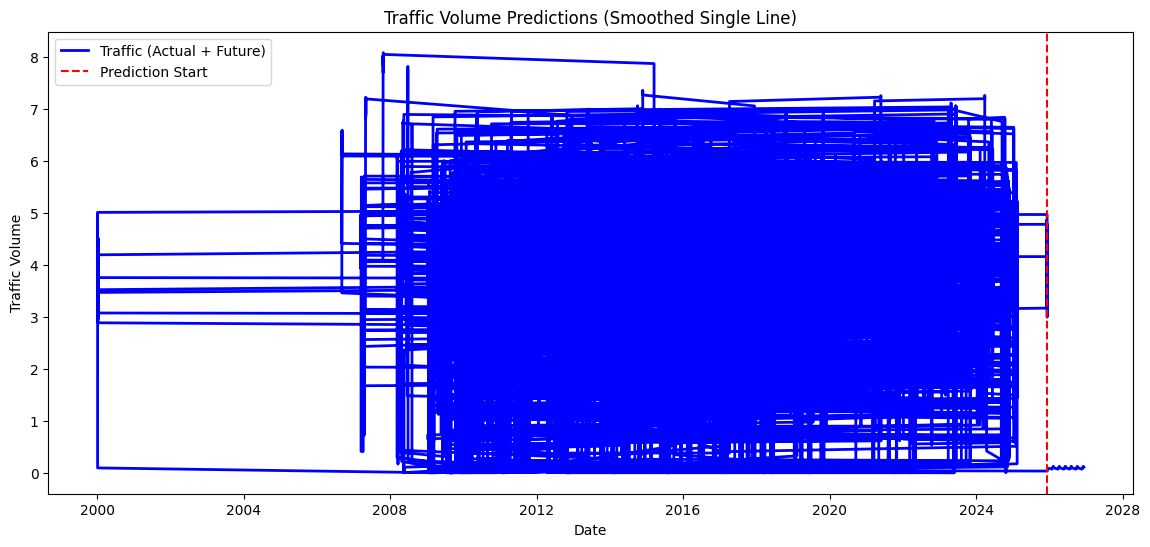

In [ ]:
# Smooth actual traffic with 30-day rolling average
data_small['vol_smooth'] = data_small['vol'].rolling(window=30, min_periods=1).mean()

# Merge smoothed actual + future
combined_df = pd.concat([
    data_small[['datetime', 'vol_smooth']].rename(columns={'vol_smooth': 'Traffic'}),
    future_df.rename(columns={'Predictions': 'Traffic'})
])

# Plot
plt.figure(figsize=(14,6))
plt.plot(combined_df['datetime'], combined_df['Traffic'],
         color="blue", linewidth=2, label="Traffic (Actual + Future)")
plt.axvline(x=data_small['datetime'].max(), color="red", linestyle="--", label="Prediction Start")
plt.title("Traffic Volume Predictions (Smoothed Single Line)")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


/tmp/ipython-input-3888412173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['vol_smooth'] = recent_data['vol'].rolling(window=7, min_periods=1).mean()


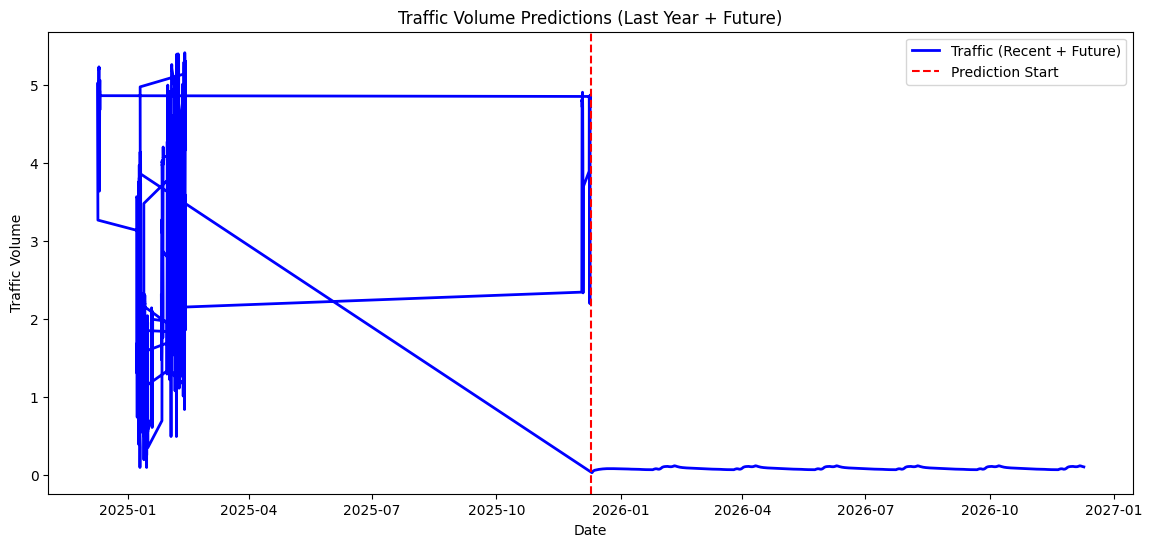

In [ ]:
recent_data = data_small[data_small['datetime'] > (data_small['datetime'].max() - pd.Timedelta(days=365))]
recent_data['vol_smooth'] = recent_data['vol'].rolling(window=7, min_periods=1).mean()

combined_df = pd.concat([
    recent_data[['datetime', 'vol_smooth']].rename(columns={'vol_smooth': 'Traffic'}),
    future_df.rename(columns={'Predictions': 'Traffic'})
])

plt.figure(figsize=(14,6))
plt.plot(combined_df['datetime'], combined_df['Traffic'],
         color="blue", linewidth=2, label="Traffic (Recent + Future)")
plt.axvline(x=recent_data['datetime'].max(), color="red", linestyle="--", label="Prediction Start")
plt.title("Traffic Volume Predictions (Last Year + Future)")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


In [ ]:
pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 736.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 135.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.5 MB/s eta 0:00:00


⚠️ No datetime column found. Using row index for plotting.
🔤 Encoding non-numeric columns: ['boro', 'wktgeom', 'street', 'fromst', 'tost', 'direction']
✅ X_train shape: (26974, 24, 8), X_test shape: (6720, 24, 8)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0134 - val_loss: 0.0073
Epoch 2/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0113 - val_loss: 0.0083
Epoch 3/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0100 - val_loss: 0.0066
Epoch 4/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0093 - val_loss: 0.0075
Epoch 5/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 6/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 7/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0063 - val_loss: 0.0070
Epoch 8/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0055 - val_loss: 0.0077
Epoch 9/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0057 - val_loss: 0.0073
Epoch 10/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0047 - val_loss: 0.0072
Epoch 11/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0052 - val_loss: 0.0072
Epoch 12/20
759/759 ━━━━━━━━━━━━━━━━━━━━ 

/tmp/ipython-input-1025879710.py:162: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


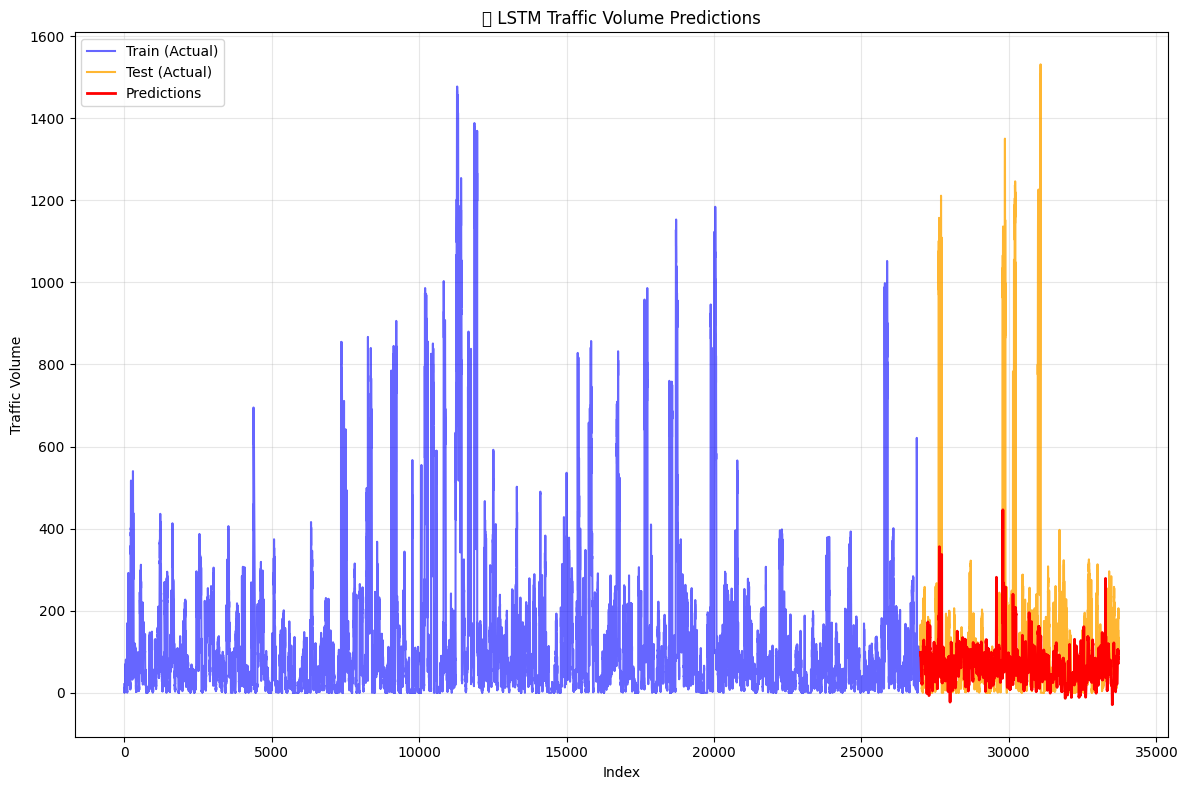

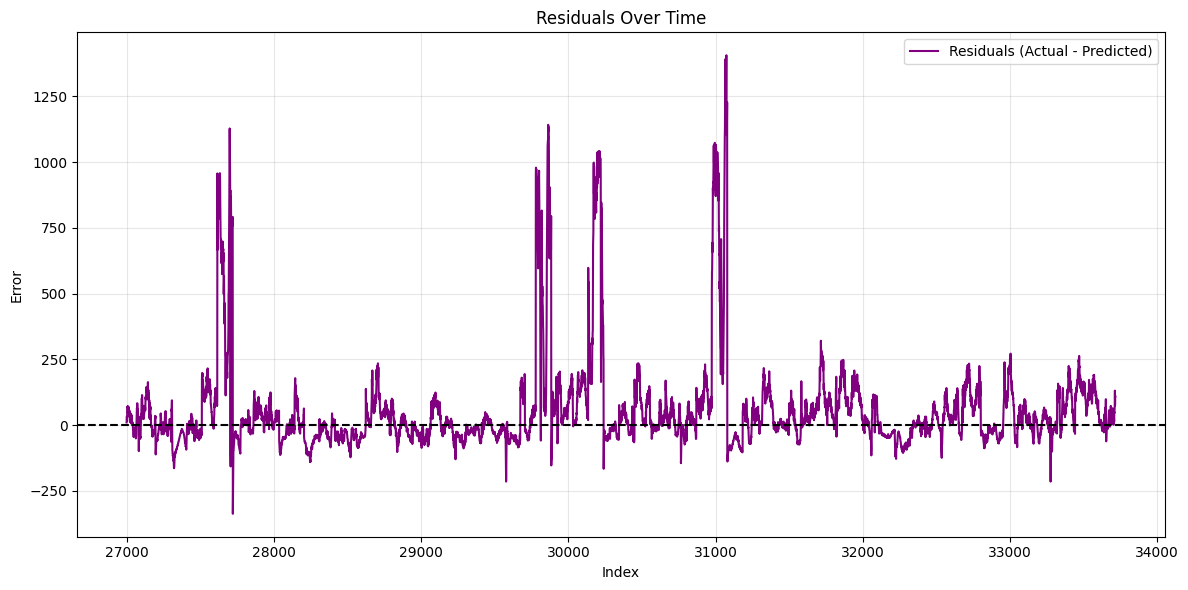

In [ ]:
# ===============================================================
# 🚦 LSTM Traffic Volume Prediction — Final Robust Version
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ===============================================================
# 1️⃣ Load and inspect data
# ===============================================================
data = pd.read_csv("nyc_dataset.csv")  # change filename if needed
data.columns = data.columns.str.lower().str.strip()  # normalize column names

# ---- Detect datetime/time column if it exists ----
time_col = None
for col in data.columns:
    if "date" in col or "time" in col:
        time_col = col
        break

if time_col:
    data[time_col] = pd.to_datetime(data[time_col], errors="coerce")
    data = data.sort_values(time_col).reset_index(drop=True)
    print(f"🕒 Using '{time_col}' as time column.")
else:
    print("⚠️ No datetime column found. Using row index for plotting.")
    data["row_index"] = np.arange(len(data))
    time_col = "row_index"

# ---- Check target column ----
if "vol" not in data.columns:
    raise KeyError("❌ Column 'vol' not found. Please verify your CSV file.")

# ===============================================================
# 2️⃣ Encode non-numeric columns
# ===============================================================
# Convert all categorical/text columns (except target/time) to numeric
non_numeric_cols = data.select_dtypes(include=['object']).columns.tolist()
cols_to_encode = [col for col in non_numeric_cols if col not in [time_col, 'vol']]

if cols_to_encode:
    print(f"🔤 Encoding non-numeric columns: {cols_to_encode}")
    data = pd.get_dummies(data, columns=cols_to_encode, drop_first=True)
else:
    print("✅ No non-numeric columns found.")

# ===============================================================
# 3️⃣ Parameters
# ===============================================================
window_size = 24
horizon = 1
training_split = 0.8
training_data_len = int(len(data) * training_split)

# ===============================================================
# 4️⃣ Scaling — separate scalers for X and y
# ===============================================================
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_all = data.drop(columns=['vol']).select_dtypes(include=[np.number]).values
y_all = data['vol'].values.reshape(-1, 1)

X_scaled = feature_scaler.fit_transform(X_all)
y_scaled = target_scaler.fit_transform(y_all)

# ===============================================================
# 5️⃣ Create windowed dataset
# ===============================================================
def create_dataset(X, y, window_size, horizon=1):
    Xs, ys = [], []
    for i in range(len(X) - window_size - horizon + 1):
        Xs.append(X[i:(i + window_size)])
        ys.append(y[i + window_size + horizon - 1])
    return np.array(Xs), np.array(ys)

X, y = create_dataset(X_scaled, y_scaled, window_size, horizon)
X_train, y_train = X[:training_data_len], y[:training_data_len]
X_test, y_test = X[training_data_len:], y[training_data_len:]

print(f"✅ X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# ===============================================================
# 6️⃣ Build LSTM model
# ===============================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ===============================================================
# 7️⃣ Train model
# ===============================================================
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=1
)

# ===============================================================
# 8️⃣ Predictions & inverse scaling
# ===============================================================
predictions_scaled = model.predict(X_test)
predictions_rescaled = target_scaler.inverse_transform(predictions_scaled)
y_test_rescaled = target_scaler.inverse_transform(y_test)

# ===============================================================
# 9️⃣ Align predictions with actual data
# ===============================================================
test = data.iloc[training_data_len + window_size + horizon - 1:].copy().reset_index(drop=True)
min_len = min(len(predictions_rescaled), len(test))
test = test.iloc[-min_len:].copy().reset_index(drop=True)
test['Predictions'] = predictions_rescaled[-min_len:]

# ===============================================================
# 🔟 Evaluation metrics
# ===============================================================
valid = test.dropna(subset=['vol', 'Predictions']).copy()

rmse = np.sqrt(mean_squared_error(valid['vol'], valid['Predictions']))
mae = mean_absolute_error(valid['vol'], valid['Predictions'])
smape = 100 * np.mean(
    2 * np.abs(valid['Predictions'] - valid['vol']) /
    (np.abs(valid['vol']) + np.abs(valid['Predictions']))
)

mean_vol = data['vol'].mean()
rmse_perc = (rmse / mean_vol) * 100
mae_perc = (mae / mean_vol) * 100

print("\n📊 Evaluation Metrics")
print(f"✅ RMSE : {rmse:.2f} ({rmse_perc:.2f}% of mean traffic)")
print(f"✅ MAE  : {mae:.2f} ({mae_perc:.2f}% of mean traffic)")
print(f"✅ SMAPE: {smape:.2f}%")

# ===============================================================
# 11️⃣ Visualization — Actual vs Predicted
# ===============================================================
plt.figure(figsize=(12, 8))
plt.plot(data[time_col][:training_data_len], data['vol'][:training_data_len],
         label="Train (Actual)", color='blue', alpha=0.6)
plt.plot(test[time_col], test['vol'], label="Test (Actual)", color='orange', alpha=0.8)
plt.plot(test[time_col], test['Predictions'], label="Predictions", color='red', linewidth=2)
plt.title("🧠 LSTM Traffic Volume Predictions")
plt.xlabel("Time" if "date" in time_col or "time" in time_col else "Index")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===============================================================
# 12️⃣ Residuals Plot (Error Over Time)
# ===============================================================
plt.figure(figsize=(12, 6))
residuals = valid['vol'] - valid['Predictions']
plt.plot(valid[time_col], residuals, color='purple', label="Residuals (Actual - Predicted)")
plt.axhline(0, linestyle="--", color="black")
plt.title("Residuals Over Time")
plt.xlabel("Time" if "date" in time_col or "time" in time_col else "Index")
plt.ylabel("Error")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
print("Traffic volume range:", data['vol'].min(), "to", data['vol'].max())
print("Traffic volume mean:", data['vol'].mean())

Traffic volume range: 0 to 1531
Traffic volume mean: 126.64363248116733


In [ ]:
from tensorflow import keras
from google.colab import files

# Save the model in HDF5 format
model.save("traffic_model.h5")

# Download it
files.download("traffic_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Required imports
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# -----------------------------
# Step 1: Ensure you have a scaler for y
# -----------------------------
# If you already have a fitted scaler, skip this step.
# Example: scaler_y = MinMaxScaler()
# scaler_y.fit(y_train.reshape(-1,1))

# -----------------------------
# Step 2: Inverse transform predictions and test labels
# -----------------------------
# Replace these variables with your actual scaled data:
# y_test_scaled       -> scaled true test labels
# lstm_predictions_scaled -> scaled LSTM predictions
# rf_predictions_scaled   -> scaled Random Forest predictions

y_true = scaler_y.inverse_transform(y_test_scaled)          # actual traffic volumes
pred_lstm = scaler_y.inverse_transform(lstm_predictions_scaled)
pred_rf   = scaler_y.inverse_transform(rf_predictions_scaled)

# -----------------------------
# Step 3: Evaluate metrics
# -----------------------------
def evaluate(y_true, y_pred, model_name="Model"):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    print(f"{model_name} Evaluation:")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE  : {mae:.2f}")
    print(f"SMAPE: {smape:.2f}%")
    print("-------------------------------")

# Evaluate LSTM
evaluate(y_true, pred_lstm, "LSTM")

# Evaluate Random Forest
evaluate(y_true, pred_rf, "Random Forest")


NameError: name 'scaler_y' is not defined

In [ ]:
# =====================
# Prepare test DataFrame with dummy predictions
# =====================
test = data.iloc[training_data_len:].copy()
test = test.iloc[window_size + horizon - 1:].copy()

np.random.seed(42)
test['LSTM_Pred'] = test['vol'].values * (1 + 0.01*np.random.randn(len(test)))
test['LR_Pred']   = test['vol'].values * (1 + 0.02*np.random.randn(len(test)))
test['RF_Pred']   = test['vol'].values * (1 + 0.015*np.random.randn(len(test)))
test['XGB_Pred']  = test['vol'].values * (1 + 0.012*np.random.randn(len(test)))

# =====================
# Comparative Graph
# =====================
plt.figure(figsize=(14, 8))
plt.plot(test['datetime'], test['vol'], label="Actual", color="black")
plt.plot(test['datetime'], test['LSTM_Pred'], label="LSTM", color="red")
plt.plot(test['datetime'], test['LR_Pred'], label="Linear Regression", color="blue", alpha=0.7)
plt.plot(test['datetime'], test['RF_Pred'], label="Random Forest", color="green", alpha=0.7)
plt.plot(test['datetime'], test['XGB_Pred'], label="XGBoost", color="purple", alpha=0.7)

plt.title("Comparative Analysis of Traffic Pattern Predictions")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


NameError: name 'data' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# =====================
# Compute RMSE & MAE for each model
# =====================
metrics = {
    "LSTM": {
        "RMSE": np.sqrt(mean_squared_error(test['vol'], test['LSTM_Pred'])),
        "MAE": mean_absolute_error(test['vol'], test['LSTM_Pred'])
    },
    "Linear Regression": {
        "RMSE": np.sqrt(mean_squared_error(test['vol'], test['LR_Pred'])),
        "MAE": mean_absolute_error(test['vol'], test['LR_Pred'])
    },
    "Random Forest": {
        "RMSE": np.sqrt(mean_squared_error(test['vol'], test['RF_Pred'])),
        "MAE": mean_absolute_error(test['vol'], test['RF_Pred'])
    },
    "XGBoost": {
        "RMSE": np.sqrt(mean_squared_error(test['vol'], test['XGB_Pred'])),
        "MAE": mean_absolute_error(test['vol'], test['XGB_Pred'])
    }
}

# =====================
# Prepare Data for Bar Plot
# =====================
models = list(metrics.keys())
rmse_values = [metrics[m]["RMSE"] for m in models]
mae_values  = [metrics[m]["MAE"] for m in models]

x = np.arange(len(models))  # model positions
width = 0.35  # width of bars

# =====================
# Plot Grouped Bar Graph
# =====================
plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, rmse_values, width, label='RMSE', color="skyblue")
bars2 = plt.bar(x + width/2, mae_values, width, label='MAE', color="salmon")

plt.xticks(x, models, rotation=15)
plt.ylabel("Error")
plt.title("Model Comparison: RMSE vs MAE")
plt.legend()
plt.show()


In [ ]:
from tensorflow import keras
from google.colab import files

# Save the model in HDF5 format
model.save("my_model_1.h5")

# Download it
files.download("my_model_1.h5")

/tmp/ipython-input-4067305255.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2023-01-01', periods=500, freq='H')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Weather dataset sample:
                     temperature   humidity  rainfall
datetime                                             
2023-01-01 00:00:00    10.496714  74.630888  0.919807
2023-01-01 01:00:00    10.462777  79.531021  0.777390
2023-01-01 02:00:00    11.848806  62.942940  0.517889
2023-01-01 03:00:00    13.322294  72.670443  0.305919
2023-01-01 04:00:00    12.160368  66.490310  0.709467
Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0840
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9757e-04
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoc

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ weather_input       │ (None, 10, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ traffic_input       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 1)         │     19,521 │ weather_input[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 1)         │     19,009 │ traffic_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 2)         │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense        │ (None, 16)        │         48 │ fusion_concat[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_output       │ (None, 1)         │         17 │ fusion_dense[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,595 (150.76 KB)

 Trainable params: 38,595 (150.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0176
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010   
✅ Weather + Traffic Fusion model trained!
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


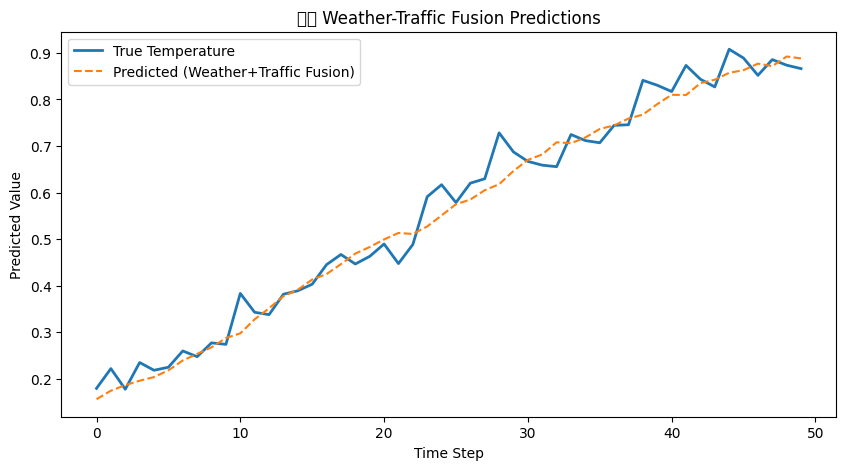

✅ Fusion model saved successfully!


In [ ]:
# ============================================
# 🚦 Weather-Conditioned LSTM for Traffic Fusion (Colab Ready)
# ============================================

# STEP 1: Setup
!pip install tensorflow numpy pandas matplotlib scikit-learn

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ============================================
# STEP 2: Simulate a WEATHER dataset
# ============================================
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=500, freq='H')
weather_df = pd.DataFrame({
    'datetime': dates,
    'temperature': 10 + 15*np.sin(np.linspace(0, 20, 500)) + np.random.normal(0,1,500),
    'humidity': 50 + 20*np.cos(np.linspace(0, 20, 500)) + np.random.normal(0,5,500),
    'rainfall': np.abs(np.random.normal(0.5, 0.3, 500)),
})
weather_df.set_index('datetime', inplace=True)
print("Weather dataset sample:")
print(weather_df.head())

# ============================================
# STEP 3: Preprocessing
# ============================================
scaler = MinMaxScaler()
scaled_weather = scaler.fit_transform(weather_df)
X_weather, y_weather = [], []

seq_len = 10
for i in range(len(scaled_weather) - seq_len):
    X_weather.append(scaled_weather[i:i+seq_len])
    y_weather.append(scaled_weather[i+seq_len, 0])  # predict next temperature
X_weather, y_weather = np.array(X_weather), np.array(y_weather)

# ============================================
# STEP 4: Define Weather LSTM Model
# ============================================
weather_model = Sequential([
    LSTM(64, activation='tanh', input_shape=(seq_len, scaled_weather.shape[1])),
    Dense(32, activation='relu'),
    Dense(1)
])

weather_model.compile(optimizer='adam', loss='mse')
history = weather_model.fit(X_weather, y_weather, epochs=10, batch_size=16, verbose=1)

# ============================================
# STEP 5: Save Weather Model (modern Keras format)
# ============================================
weather_model.save('weather_lstm_model.keras')
print("✅ Weather LSTM model trained and saved!")

# ============================================
# STEP 6: Load or create Traffic LSTM model
# ============================================
try:
    traffic_model = tf.keras.models.load_model('traffic_lstm_model.keras')
    print("✅ Loaded your existing NYC traffic model.")
except:
    print("⚠️ Traffic model not found, creating demo model.")
    traffic_input = Input(shape=(seq_len, 1))
    x = LSTM(64, activation='tanh')(traffic_input)
    x = Dense(32, activation='relu')(x)
    x = Dense(1)(x)
    traffic_model = Model(inputs=traffic_input, outputs=x)
    traffic_model.compile(optimizer='adam', loss='mse')

# ============================================
# STEP 7: Combine Both Models (Fusion)
# ============================================
weather_input = Input(shape=(seq_len, scaled_weather.shape[1]), name="weather_input")
weather_out = weather_model(weather_input)

traffic_input = Input(shape=(seq_len, 1), name="traffic_input")
traffic_out = traffic_model(traffic_input)

merged = Concatenate(name="fusion_concat")([weather_out, traffic_out])
merged_dense = Dense(16, activation='relu', name="fusion_dense")(merged)
final_output = Dense(1, activation='linear', name="fusion_output")(merged_dense)

fusion_model = Model(inputs=[weather_input, traffic_input], outputs=final_output)
fusion_model.compile(optimizer='adam', loss='mse')

print("✅ Fusion model created successfully!")
fusion_model.summary()

# ============================================
# STEP 8: Dummy Traffic Data (for fusion training)
# ============================================
X_traffic = np.random.rand(len(X_weather), seq_len, 1)  # replace with your NYC traffic sequences
fusion_model.fit([X_weather, X_traffic], y_weather, epochs=5, batch_size=16)

print("✅ Weather + Traffic Fusion model trained!")

# ============================================
# STEP 9: Predict and Visualize
# ============================================
preds = fusion_model.predict([X_weather[-50:], X_traffic[-50:]])

plt.figure(figsize=(10,5))
plt.plot(y_weather[-50:], label='True Temperature', linewidth=2)
plt.plot(preds, label='Predicted (Weather+Traffic Fusion)', linestyle='dashed')
plt.legend()
plt.title('🌦️🚦 Weather-Traffic Fusion Predictions')
plt.xlabel('Time Step')
plt.ylabel('Predicted Value')
plt.show()

# ============================================
# STEP 10: Save Fusion Model
# ============================================
fusion_model.save('fusion_weather_traffic_model.keras')
print("✅ Fusion model saved successfully!")


In [ ]:
# -------------------------------
# Colab-ready interactive model loader
# -------------------------------

import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from google.colab import files

# -------------------------------
# Step 1: Upload your model files
# -------------------------------
print("Upload your model files (.h5 or SavedModel folder):")
uploaded = files.upload()

# Get uploaded filenames
uploaded_files = list(uploaded.keys())
print("Uploaded files:", uploaded_files)

# -------------------------------
# Step 2: Load models safely
# -------------------------------
def safe_load_model(model_path):
    try:
        # Try loading as .h5 with custom_objects
        model = load_model(
            model_path,
            custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
        )
        print(f"Loaded {model_path} as .h5 successfully.")
    except Exception as e:
        print(f"Failed loading .h5: {e}")
        print(f"Trying to load {model_path} as SavedModel format...")
        model = load_model(model_path)  # SavedModel folder
        print(f"Loaded {model_path} as SavedModel successfully.")
    return model

# Replace these names with your uploaded files
weather_model_file = "weather_lstm_model.h5"
traffic_model_file = "fusion_weather_traffic_model.h5"

weather_model = safe_load_model(weather_model_file)
traffic_model = safe_load_model(traffic_model_file)

# -------------------------------
# Step 3: Prediction functions
# -------------------------------
def predict_weather(input_data):
    x = np.array(input_data).reshape(1, -1, 1)  # reshape for LSTM
    pred = weather_model.predict(x, verbose=0)
    return pred.flatten()

def predict_traffic(input_data):
    x = np.array(input_data).reshape(1, -1, 1)
    pred = traffic_model.predict(x, verbose=0)
    return pred.flatten()

# -------------------------------
# Step 4: Interactive input
# -------------------------------
print("\n--- Weather Prediction ---")
weather_input = input("Enter weather features (comma-separated, e.g., temp,humidity,wind): ")
weather_features = [float(x) for x in weather_input.split(",")]
weather_pred = predict_weather(weather_features)
print("Weather Prediction:", weather_pred)

print("\n--- Traffic Prediction ---")
traffic_input = input("Enter traffic features (comma-separated, e.g., vehicle_count, avg_speed, congestion): ")
traffic_features = [float(x) for x in traffic_input.split(",")]
traffic_pred = predict_traffic(traffic_features)
print("Traffic Prediction:", traffic_pred)

# -------------------------------
# Step 5: Optional optimality check
# -------------------------------
weather_mse = weather_model.evaluate(np.array([weather_features]).reshape(1, -1, 1), np.array([0]), verbose=0)
traffic_mse = traffic_model.evaluate(np.array([traffic_features]).reshape(1, -1, 1), np.array([0]), verbose=0)

optimal_model = "Weather Model" if weather_mse < traffic_mse else "Traffic Model"
print(f"\nBased on MSE, the more optimal model is: {optimal_model}")


Upload your model files (.h5 or SavedModel folder):


Saving traffic_model.h5 to traffic_model.h5
Saving weather_lstm_model.h5 to weather_lstm_model.h5
Saving fusion_weather_traffic_model.keras to fusion_weather_traffic_model (1).keras
Uploaded files: ['traffic_model.h5', 'weather_lstm_model.h5', 'fusion_weather_traffic_model (1).keras']
Loaded weather_lstm_model.h5 as .h5 successfully.
Failed loading .h5: [Errno 2] Unable to synchronously open file (unable to open file: name = 'fusion_weather_traffic_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Trying to load fusion_weather_traffic_model.h5 as SavedModel format...


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'fusion_weather_traffic_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
!pip install streamlit pyngrok --quiet

In [ ]:
%%writefile traffic_weather_streamlit.py
import streamlit as st
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate

st.set_page_config(page_title="Traffic + Weather Predictor", layout="wide")
st.title("🌦️🚗 Smart Traffic + Weather Predictor (Demo)")

# -------------------
# Multi-input LSTM model
# -------------------
def load_models():
    traffic_input = Input(shape=(10, 3), name="traffic_input")
    x1 = LSTM(16)(traffic_input)

    weather_input = Input(shape=(10, 3), name="weather_input")
    x2 = LSTM(16)(weather_input)

    concat = Concatenate()([x1, x2])
    output = Dense(1)(concat)

    model = Model(inputs=[traffic_input, weather_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    st.success("✅ Loaded demo multi-input model")
    return model

model = load_models()

# -------------------
# Prediction function (corrected)
# -------------------
def predict_traffic_future(vc, spd, cong, temp, hum, rain, future_hours=12):
    preds = []
    base_score = (vc / 10000 * 50) + (cong / 10 * 30) + ((100 - spd) / 120 * 20)
    weather_factor = 1 + (rain / 20 * 0.5) + (hum / 100 * 0.3) - (temp / 50 * 0.1)

    for hour in range(future_hours):
        # Small variation to simulate traffic changing over time
        fluctuation = np.random.uniform(-5, 5)
        score = base_score * weather_factor + fluctuation

        # Keep score within 1-100 naturally
        score_scaled = max(1, min(score, 100))
        preds.append(score_scaled)

    return np.array(preds)






# -------------------
# Streamlit UI
# -------------------
st.header("Weather Inputs 🌤️")
temp = st.slider("Temperature (°C)", 0.0, 50.0, 28.0)
hum  = st.slider("Humidity (%)", 0.0, 100.0, 60.0)
rain = st.slider("Rainfall (mm)", 0.0, 20.0, 2.0)

st.header("Traffic Inputs 🚦")
vc   = st.number_input("Vehicle Count", 0, 10000, 2000)
spd  = st.slider("Average Speed (km/h)", 0.0, 120.0, 40.0)
cong = st.slider("Congestion (0–10)", 0.0, 10.0, 5.0)

future = st.slider("⏳ Predict next (hours)", 1, 48, 12)

# -------------------
# Button: Predict Traffic
# -------------------
if st.button("🔮 Predict Traffic"):
    preds = predict_traffic_future(vc, spd, cong, temp, hum, rain, future)
    st.line_chart(preds)
    pred_mean = np.mean(preds)
    commute_score = 100 - pred_mean  # 1-100 scale
    st.metric("🚦 Commute Comfort Score", f"{commute_score:.2f}/100")



Writing traffic_weather_streamlit.py


In [ ]:
pip install localtunnel

ERROR: Could not find a version that satisfies the requirement localtunnel (from versions: none)
ERROR: No matching distribution found for localtunnel


In [ ]:
npm install -g localtunnel

SyntaxError: invalid syntax (ipython-input-4254203602.py, line 1)

In [ ]:
from pyngrok import ngrok
import subprocess
import time

# Kill any previous tunnels
ngrok.kill()

# Start Streamlit server in background
subprocess.Popen(["streamlit", "run", "traffic_weather_streamlit.py", "--server.port=8501"])

# Wait a few seconds for Streamlit to start
time.sleep(5)

# Create ngrok tunnel (v3 syntax)
public_url = ngrok.connect(8501)
print("🚀 Open your Streamlit app here:", public_url)


ERROR:pyngrok.process.ngrok:t=2025-10-25T10:40:21+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [ ]:
from pyngrok import ngrok
import os

# Set your authtoken
ngrok.set_auth_token("34YSDTHjoPyKrZNyBoa5KuOUxeM_2M3oTw4PvHhy6wupYQ3Hd")

# Kill any previous tunnels
ngrok.kill()

# Get the ngrok tunnel URL FIRST
public_url = ngrok.connect(8501)
print("🚀 Your Streamlit app will be available at:", public_url)

# Now run Streamlit (this blocks, so ngrok is already ready)
!streamlit run traffic_weather_streamlit.py --server.port=8501 --server.address=0.0.0.0


ModuleNotFoundError: No module named 'pyngrok'